# C1 - Content Based Image Retrieval
### Team 8

In [4]:
import numpy as np
import cv2
import glob
import tqdm
import pickle
import os
import math

In [5]:
class DataLoader():
    def __init__(self, folder_path):
        self.folder_path = folder_path

    def get_mask(self, im, look=4, mode='lab'):
        thresholds = []
        for channel in range(3):
            if mode == 'lab' and channel == 0:
                thresholds.append((None, None))
                continue
            arr = np.concatenate([im[:look, :, channel].flatten(), im[-look:, :, channel].flatten(), im[:, -look:, channel].flatten(),  im[:, :look, channel].flatten()])
            thresholds.append((np.min(arr), np.max(arr)))
            
        mask = np.ones(im.shape[:2])
        for channel in range(3):
            if mode == 'lab' and channel == 0:
                continue
            mask = mask * np.where((im[:,:,channel] > thresholds[channel][0]) & (im[:,:,channel] < thresholds[channel][1]), 1, 0)

        return 1-mask

    def load_data(self, blocks=False, blockNumber=16, remove_background=False):
        # Get a list of all image file names in the folder
        image_files = glob.glob(self.folder_path+'/*.jpg')

        # Initialize an empty list to store the processed images and masks
        processed_features_rgb = dict()
        processed_features_hsv = dict()
        processed_features_lab = dict()
        masks = []

        # Iterate over each image file
        for f in tqdm.tqdm(image_files):

            img_id = int(f.split('\\')[-1].split('.')[0].split('_')[-1])

            # Load the image
            image = cv2.imread(f)

            # Convert the image from BGR to lab color space
            image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

            # Convert the image from BGR to HSV color space
            image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            # Remove background
            if remove_background:
                mask_rgb = self.get_mask(image, look=60, mode='rgb')
                mask_hsv = self.get_mask(image_hsv, look=60, mode='hsv')
                mask_lab = self.get_mask(image_lab, look=60, mode='lab')
            else:
                mask_rgb, mask_hsv, mask_lab = None, None, None

            masks.append([mask_rgb, mask_hsv, mask_lab])

            if blocks:
                # Get the features of the image
                features = self.get_features_by_blocks(image, blockNumber, 'rgb', mask=mask_rgb)
                features_hsv = self.get_features_by_blocks(image_hsv, blockNumber, 'hsv', mask=mask_hsv)
                features_lab = self.get_features_by_blocks(image_lab, blockNumber, 'lab', mask=mask_lab)
            else:
                features = self.get_features(image, 'rgb', mask=mask_rgb)
                features_hsv = self.get_features(image_hsv, 'hsv', mask=mask_hsv) # h: (0,179), s,v: (0,255)
                features_lab = self.get_features(image_lab, 'lab', mask=mask_lab) # l: (0,255), a,b: (0,255)

            # Append the features to the dict
            processed_features_rgb[img_id] = features
            processed_features_hsv[img_id] = features_hsv
            processed_features_lab[img_id] = features_lab

        return processed_features_rgb, processed_features_hsv, processed_features_lab, masks
    

    def create_blocks_array(self, image, blockNumber):
        # Set number of slices per axis
        axisSlice = int(math.sqrt(blockNumber))

        blocksArray = []
        # Split the image into vertical blocks
        split_h = np.array_split(image, axisSlice, axis = 0)
        for i in range(axisSlice):
            for j in range(axisSlice):
                # Split vertical blocks into square blocks
                split_hv = np.array_split(split_h[i], axisSlice, axis = 1)
                blocksArray.append(split_hv[j])
        return blocksArray
    
    def get_features_by_blocks(self, image, blockNumber, mode, mask=None):
        
        # Get the blocks array
        blocksArray = self.create_blocks_array(image, blockNumber)
        
        # Initialize an empty list to store the histograms
        histograms = []

        if mask is not None:
            blocksMasks = self.create_blocks_array(mask, blockNumber)

            for block, mask_i in zip(blocksArray, blocksMasks):
                for i, channel in enumerate(cv2.split(block)):
                    if mode == 'hsv' and i == 0:
                        range = 180
                    else:
                        range = 256
                    # Compute the histogram of the channel and append it to the list
                    hist, _ = np.histogram(channel[mask_i != 0], bins=int(range/6), range=(0, range))
                    histograms.append(hist / (block.shape[0] * block.shape[1]))
        else:
            for block in blocksArray:
                for i, channel in enumerate(cv2.split(block)):
                    if mode == 'hsv' and i == 0:
                        range = 180
                    else:
                        range = 256
                    # Compute the histogram of the channel and append it to the list
                    hist, _ = np.histogram(channel, bins=int(range/6), range=(0, range))
                    histograms.append(hist  / (block.shape[0] * block.shape[1]))

        # Concatenate all histograms into a single feature vector
        return np.concatenate(histograms)
    
    def get_features(self, image, mode, mask=None):
        channels = cv2.split(image)

        # Initialize an empty list to store the histograms
        histograms = []

        if mask is not None:
            for i, channel in enumerate(channels):
                if mode == 'hsv' and i == 0:
                    range = 180
                else:
                    range = 256
                # Compute the histogram of the channel and append it to the list
                hist, _ = np.histogram(channel[mask != 0], bins=int(range/6), range=(0, range))
                histograms.append(hist / (image.shape[0] * image.shape[1]))
        else:
            for i, channel in enumerate(channels):
                if mode == 'hsv' and i == 0:
                    range = 180
                else:
                    range = 256
                # Compute the histogram of the channel and append it to the list
                hist, _ = np.histogram(channel, bins=int(range/6), range=(0, range))
                histograms.append(hist / (image.shape[0] * image.shape[1]))

        # Concatenate all histograms into a single feature vector
        return np.concatenate(histograms)

In [6]:
# Copied from https://github.com/benhamner/Metrics -> Metrics.Python.ml_metrics.average_precision.py
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

# Copied from https://github.com/benhamner/Metrics -> Metrics.Python.ml_metrics.average_precision.py
def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

# compute the histogram intersection between two feature vectors
def histogram_intersection(hist1, hist2):
    return np.sum(np.minimum(hist1, hist2))

# compute the euclidian distance between two feature vectors
def euclidian_distance(hist1, hist2):
    return np.sqrt(np.sum(np.square(hist1 - hist2)))

# compute the chi-squared distance between two feature vectors
def chi_squared_distance(hist1, hist2):
    return np.sum(np.square(hist1 - hist2) / (hist1 + hist2 + 1e-10))

# compute the bhattacharyya distance between two feature vectors
def bhattacharyya_distance(hist1, hist2):
    # Ensure that both histograms have the same shape
    assert hist1.shape == hist2.shape, "Histograms must have the same shape"
    # Calculate the Bhattacharyya coefficient
    bhattacharyya_coeff = np.sum(np.sqrt(hist1 * hist2))
    # Calculate the Bhattacharyya distance
    bhattacharyya_distance = -np.log(bhattacharyya_coeff)
    return bhattacharyya_distance

# compute the Helling distance (Hellinger kernel) between two feature vectors
def hellinger_kernel(hist1, hist2):
    return np.sum(np.sqrt(hist1*hist2))

def compare_images(query_features, bbdd_features, k, sim_func):
    result = []
    for id1,f1 in query_features.items():
        distances = []
        for id2,f2 in bbdd_features.items():
            distances.append((id2, sim_func(f1,f2)))

        #get k smallest values from distances
        if sim_func in [euclidian_distance, chi_squared_distance, bhattacharyya_distance]:
            k_smallest = sorted(distances, reverse=False, key=lambda x: x[1])[:k]
        else:
            k_smallest = sorted(distances, reverse=True, key=lambda x: x[1])[:k]
        result.append((id1, k_smallest))
        
    result2 = []
    for x in result:
        result2.append([y[0] for y in x[1]])
    
    return result2

In [7]:
def performance_accumulation_pixel(pixel_candidates, pixel_annotation):
    """ 
    performance_accumulation_pixel()

    Function to compute different performance indicators 
    (True Positive, False Positive, False Negative, True Negative) 
    at the pixel level
       
    [pixelTP, pixelFP, pixelFN, pixelTN] = performance_accumulation_pixel(pixel_candidates, pixel_annotation)
       
    Parameter name      Value
    --------------      -----
    'pixel_candidates'   Binary image marking the foreground areas
    'pixel_annotation'   Binary image containing ground truth
       
    The function returns the number of True Positive (pixelTP), False Positive (pixelFP), 
    False Negative (pixelFN) and True Negative (pixelTN) pixels in the image pixel_candidates
    """
    
    pixel_candidates = np.uint64(pixel_candidates>0)
    pixel_annotation = np.uint64(pixel_annotation>0)
    
    pixelTP = np.sum(pixel_candidates & pixel_annotation)
    pixelFP = np.sum(pixel_candidates & (pixel_annotation==0))
    pixelFN = np.sum((pixel_candidates==0) & pixel_annotation)
    pixelTN = np.sum((pixel_candidates==0) & (pixel_annotation==0))


    return [pixelTP, pixelFP, pixelFN, pixelTN]

In [9]:
# Load ground truth files for each query
with open('qsd1_w1/gt_corresps.pkl', 'rb') as f:
    gt1 = pickle.load(f)

with open('qsd2_w1/gt_corresps.pkl', 'rb') as f:
    gt2 = pickle.load(f)

In [20]:
q1 = cv2.imread('qsd1_w1/00000.jpg')

def get_features(image, mode, mask=None):
    channels = cv2.split(image)

    # Initialize an empty list to store the histograms
    histograms = []

    if mask is not None:
        for i, channel in enumerate(channels):
            if mode == 'hsv' and i == 0:
                range = 180
            else:
                range = 256
            # Compute the histogram of the channel and append it to the list
            hist, _ = np.histogram(channel[mask != 0], bins=int(range/6), range=(0, range))
            histograms.append(hist / (image.shape[0] * image.shape[1]))
    else:
        for i, channel in enumerate(channels):
            if mode == 'hsv' and i == 0:
                range = 180
            else:
                range = 256
            # Compute the histogram of the channel and append it to the list
            hist, _ = np.histogram(channel, bins=int(range/6), range=(0, range))
            histograms.append(hist / (image.shape[0] * image.shape[1]))

    # Concatenate all histograms into a single feature vector
    return np.concatenate(histograms)

f1 = get_features(q1, 'rgb')

## Validation results

### Method 1:
- Represent the original image in the HSV color space.
- Image descriptor: Concatenate the normalised histograms of the 3 image channels.
- Chi-square distance as the similarity function.

In [7]:
# Retrieval parameters
k = 10
sim_func = chi_squared_distance

# Create DataLoader objects for both the database and the queries
data_loader = DataLoader('data/BBDD')
_, features_hsv, _, _ = data_loader.load_data(blocks=False)

data_loader_q1 = DataLoader('data/qsd1_w1')
_, features_hsv_q1, _, _ = data_loader_q1.load_data(blocks=False)

data_loader_q2 = DataLoader('data/qsd2_w1')
_, features_hsv_q2, _, _ = data_loader_q1.load_data(blocks=False)
_, features_hsv_q2_no_back, _, masks = data_loader_q2.load_data(blocks=False, remove_background=True)

  0%|          | 0/287 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:05<00:00,  5.99it/s]


In [8]:
# Query 1: Results and mAP@k
results_hsv_q1 = compare_images(features_hsv_q1, features_hsv, k, sim_func)

mapk_lab_1 = mapk(gt1, results_hsv_q1, 1)
mapk_lab_5 = mapk(gt1, results_hsv_q1, 5)
mapk_lab_10 = mapk(gt1, results_hsv_q1, 10)

mapk_lab_1, mapk_lab_5, mapk_lab_10

(0.43333333333333335, 0.5272222222222223, 0.5367460317460317)

In [9]:
# Query 2: Results and mAP@k
results_hsv_q2 = compare_images(features_hsv_q2, features_hsv, k, sim_func)

mapk_lab_1 = mapk(gt2, results_hsv_q2, 1)
mapk_lab_5 = mapk(gt2, results_hsv_q2, 5)
mapk_lab_10 = mapk(gt2, results_hsv_q2, 10)

mapk_lab_1, mapk_lab_5, mapk_lab_10

(0.03333333333333333, 0.03333333333333333, 0.03333333333333333)

In [10]:
# Query 2, removing background: Results and mAP@k
results_hsv_q2_no_back = compare_images(features_hsv_q2_no_back, features_hsv, k, sim_func)

mapk_lab_1 = mapk(gt2, results_hsv_q2_no_back, 1)
mapk_lab_5 = mapk(gt2, results_hsv_q2_no_back, 5)
mapk_lab_10 = mapk(gt2, results_hsv_q2_no_back, 10)

mapk_lab_1, mapk_lab_5, mapk_lab_10

(0.3, 0.35, 0.3584656084656085)

### Method 2:
- Represent the original image in the CIE Lab color space.
- Image descriptor: Divide the image in 256 blocks, get the histogram for each one and concatenate all of them.
- Histogram intersection as the similarity function.

In [36]:
# Retrieval parameters
k = 10
sim_func = histogram_intersection

# Create DataLoader objects for both the database and the queries
data_loader = DataLoader('BBDD')
_, _, features_lab, _ = data_loader.load_data(blocks=True, blockNumber=4)

data_loader_q1 = DataLoader('qsd1_w1')
_, _, features_lab_q1, _ = data_loader_q1.load_data(blocks=True, blockNumber=4)

data_loader_q2 = DataLoader('qsd2_w1')
# _, _, features_lab_q2, _ = data_loader_q2.load_data(blocks=True, blockNumber=256)
_, _, features_lab_q2_no_back, masks = data_loader_q2.load_data(blocks=True, blockNumber=4, remove_background=True)

  0%|          | 0/287 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


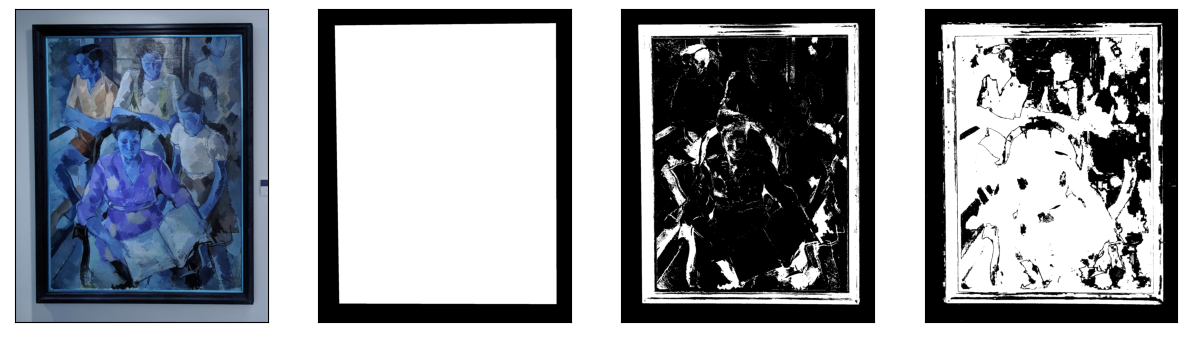

In [60]:
import matplotlib.pyplot as plt
ids = 6
image = cv2.imread(f'qsd2_w1/0000{ids}.jpg')
mask_gt = cv2.imread(f'qsd2_w1/0000{ids}.png')
mask1 = masks[ids][0]
mask2 = masks[ids][2]

fig, ax = plt.subplots(1,4, figsize=(15,15))

ax[0].imshow(image)
ax[1].imshow(mask_gt, cmap='gray')
ax[2].imshow(mask1, cmap='gray')
ax[3].imshow(mask2, cmap='gray')

# not show axis
for a in ax:
    a.set_xticks([])
    a.set_yticks([])


In [12]:
# Query 1: Results and mAP@k
results_lab_q1 = compare_images(features_lab_q1, features_lab, k, sim_func)

mapk_lab_1 = mapk(gt1, results_lab_q1, 1)
mapk_lab_5 = mapk(gt1, results_lab_q1, 5)
mapk_lab_10 = mapk(gt1, results_lab_q1, 10)

mapk_lab_1, mapk_lab_5, mapk_lab_10

(0.9333333333333333, 0.94, 0.94)

In [13]:
# Query 2: Results and mAP@k
results_lab_q2 = compare_images(features_lab_q2, features_lab, k, sim_func)

mapk_lab_1 = mapk(gt2, results_lab_q1, 1)
mapk_lab_5 = mapk(gt2, results_lab_q1, 5)
mapk_lab_10 = mapk(gt2, results_lab_q1, 10)

mapk_lab_1, mapk_lab_5, mapk_lab_10

(0.03333333333333333, 0.041666666666666664, 0.041666666666666664)

In [14]:
# Query 2, removing background: Results and mAP@k
results_lab_q2_no_back = compare_images(features_lab_q2_no_back, features_lab, k, sim_func)

mapk_lab_1 = mapk(gt2, results_lab_q2_no_back, 1)
mapk_lab_5 = mapk(gt2, results_lab_q2_no_back, 5)
mapk_lab_10 = mapk(gt2, results_lab_q2_no_back, 10)

mapk_lab_1, mapk_lab_5, mapk_lab_10

(0.5, 0.5344444444444444, 0.5423148148148148)

### Precision, Recall and F1-score of the masking method

In [15]:
folder_path = "data/qsd2_w1"

precision, recall, f1 = [], [], []
for i, im_file in enumerate(glob.glob(os.path.join(folder_path, "*.png"))):
    mask_gt = cv2.imread(im_file, cv2.IMREAD_GRAYSCALE)
    pixelTP, pixelFP, pixelFN, pixelTN = performance_accumulation_pixel(masks[i][2], mask_gt)

    p = pixelTP / (pixelTP + pixelFP)
    r = pixelTP / (pixelTP + pixelFN)

    precision.append(p)
    recall.append(r)
    f1.append(2 * (p * r) / (p + r))

print("Precision:", np.mean(precision))
print("Recall:", np.mean(recall))
print("F1-score:", np.mean(f1))

Precision: 0.9161133482286591
Recall: 0.6968414832722183
F1-score: 0.749814857836167


## Get test results from both queries

#### Method 1:

In [ ]:
# Create DataLoader objects for both the database and the queries
data_loader = DataLoader('data/BBDD')
_, features_hsv, _, _ = data_loader.load_data(blocks=False)

data_loader_q1 = DataLoader('data/qst1_w1')
_, features_hsv_q1, _, _ = data_loader_q1.load_data(blocks=False)

data_loader_q2_no_back = DataLoader('data/qst2_w1')
_, features_hsv_q2_no_back, _, masks = data_loader_q2_no_back.load_data(blocks=False, remove_background=True)

In [ ]:
# Retrieval parameters
k = 10
sim_func = chi_squared_distance

# Get results
results_hsv_q1 = compare_images(features_hsv_q1, features_hsv, k, sim_func)
results_hsv_q2_no_back = compare_images(features_hsv_q2_no_back, features_hsv, k, sim_func)

In [ ]:
# Save results as pickle files and masks as png images
with open("test_results/QST1/method1/results.pkl", "wb") as f:
    pickle.dump(results_hsv_q1, f)

with open("test_results/QST2/method1/results.pkl", "wb") as f:
    pickle.dump(results_hsv_q2_no_back, f)

for i, mask in enumerate(masks):
    final_mask = (mask[0]*mask[1]*mask[2])*255
    image_mask_name = str(i).zfill(5) + ".png"
    cv2.imwrite(os.path.join("test_results/QST2/method1/", image_mask_name), final_mask)

#### Method 2

In [ ]:
# Create DataLoader objects for both the database and the queries
data_loader = DataLoader('data/BBDD')
_, _, features_lab, _ = data_loader.load_data(blocks=True, blockNumber=256)

data_loader_q1 = DataLoader('data/qst1_w1')
_, _, features_lab_q1, _ = data_loader_q1.load_data(blocks=True, blockNumber=256)

data_loader_q2_no_back = DataLoader('data/qst2_w1')
_, _, features_lab_q2_no_back, masks = data_loader_q2_no_back.load_data(blocks=True, blockNumber=256, remove_background=True)

In [ ]:
# Retrieval parameters
k = 10
sim_func = histogram_intersection

# Get results
results_lab_q1 = compare_images(features_lab_q1, features_lab, k, sim_func)
results_lab_q2_no_back = compare_images(features_lab_q2_no_back, features_lab, k, sim_func)

In [ ]:
# Save result lists as pickle files and masks as png images
with open("test_results/QST1/method2/results.pkl", "wb") as f:
    pickle.dump(results_lab_q1, f)

with open("test_results/QST2/method2/results.pkl", "wb") as f:
    pickle.dump(results_lab_q2_no_back, f)

for i, mask in enumerate(masks):
    final_mask = (mask[0]*mask[1]*mask[2])*255
    image_mask_name = str(i).zfill(5) + ".png"
    cv2.imwrite(os.path.join("test_results/QST2/method2/", image_mask_name), final_mask)